In [1]:
import pickle
import numpy as np
import networkx as nx
import pandas as pd
import brainmaptools as brainmap
import matplotlib.pyplot as plt
import community
import brainx.modularity as mod
import operator
%matplotlib inline
import csv
import scipy as scipy
import scipy.io as io
import My_functions as myfunctions
import progressbar as pb
import time
import os
%load_ext Cython
import bct
from numba import jit
from tqdm import tqdm

/Users/owner/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/brainx/__init__.py:30: UserWarning: Monkeypatching NetworkX's Watts-Strogatz routine
  warnings.warn("Monkeypatching NetworkX's Watts-Strogatz routine")


In [2]:
path = '/Users/owner/Documents/MATLAB/Add_Ons/BrainNetViewer_20171031/Data/NodeFiles/CSV/Label_coordinates.csv'
outdir='/Users/owner/Documents/MATLAB/Add_Ons/BrainNetViewer_20171031/Data/NodeFiles/CSV/'

In [3]:
domains= ['Memory', 'Working Memory', 'Attention', 'Language', 'Emotion','Vision', 'Audition', 'Base']

In [4]:
relabel_dict_file='/Users/owner/PFC_MetaConnectome/Scripts/Label_dict.pck'
relabel_dict=pickle.load(open(relabel_dict_file,"rb"))

In [5]:
G_nothresh={}
for x in domains:
    filename='G_nothresh_jaccard_'+x+'_.pck'
    workdir='/Users/owner/PFC_MetaConnectome/Results/G_jaccard_graphs/Unthresholded_G_jaccard/'
    output=workdir+filename
    G_nothresh[x]=pickle.load(open (output, 'rb'))

# BCTPY Newman

In [6]:
bct_mod={}
bct_part={}
bct_partition={}
for x in domains:
    bct_mod[x]=bct.modularity_und(np.squeeze(np.asarray(nx.to_numpy_matrix(G_nothresh[x]))))
    bct_part[x]=dict(zip(G_nothresh[x].nodes(), bct_mod[x][0]))
    bct_partition[x]=brainmap.make_brainx_style_partition(bct_part[x])

In [7]:
for x in domains:
    print x, '|', bct_mod[x][1]

Memory | 0.175464615461
Working Memory | 0.222097379566
Attention | 0.189318595584
Language | 0.248974168101
Emotion | 0.162290264322
Vision | 0.302636385616
Audition | 0.436937697958
Base | 0.165184025669


Mutual Information Matrix

/Users/owner/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/brainx/modularity.py:1004: RuntimeWarning: divide by zero encountered in log
  num = nansum(N*log(N*nn/(nsum_row*nsum_col)))
/Users/owner/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/brainx/modularity.py:1004: RuntimeWarning: invalid value encountered in multiply
  num = nansum(N*log(N*nn/(nsum_row*nsum_col)))


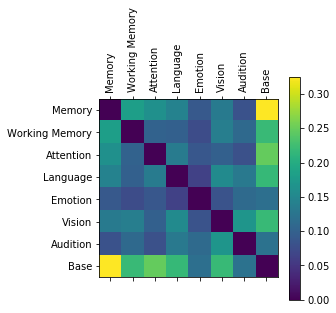

In [8]:
mutual_matrix_bct_new=np.zeros([len(domains),len(domains)])
for x,y in enumerate(domains):
    for a,b in enumerate(domains):
        mutual_matrix_bct_new[x][a]=mod.mutual_information(bct_partition[y],bct_partition[b])
np.fill_diagonal(mutual_matrix_bct_new,0)
plt.matshow(mutual_matrix_bct_new)        
plt.xticks(range(len(domains)), domains, rotation='90')
plt.yticks(range(len(domains)), domains)
plt.colorbar()


Statistical Significance

In [11]:
bct_rand_mod_list=pickle.load(open('/Users/owner/PFC_MetaConnectome/Scripts/bct_rand_mod_list.pck', 'rb'))

IOError: [Errno 2] No such file or directory: '/Users/owner/PFC_MetaConnectome/Scripts/bct_rand_mod_list.pck'

In [9]:
mean={}
std={}
z={}
for x in domains:
    mean[x]=np.mean(bct_rand_mod_list[x])
    std[x]=np.std(bct_rand_mod_list[x])
    z[x]=((bct_mod[x][1]-mean[x])/std[x])
    if z[x] > 1.96:
        print x, '| Q =', bct_mod[x][1], '| Z =', z[x], '| M =', mean[x]

NameError: name 'bct_rand_mod_list' is not defined

Save Partition as BrainNet File

In [ ]:
for x in domains:
    myfunctions.node_file(bct_part[x], y=basic_metrics[x]['between_cent'], filename='bct_nothresh_'+x+'_node.csv')
    csv_file = '/Users/owner/Desktop/BrainImagingViewer/BrainNetViewer_20171031/Data/NodeFiles/bct_nothresh_'+x+'_node.csv'
    txt_file = '/Users/owner/Desktop/BrainImagingViewer/BrainNetViewer_20171031/Data/NodeFiles/Nothresh/bct_nothresh_'+x+'_node.node'
    with open(txt_file, "w") as my_output_file:
        with open(csv_file, "r") as my_input_file:
            [ my_output_file.write(" ".join(row)+'\n') for row in csv.reader(my_input_file)]
        my_output_file.close()

# Louvain

Remove Weight Attribute

In [9]:
G_noweight={x: brainmap.remove_weight_edge_attribute(G_nothresh[x]) for x in domains }

In [10]:
Louvain_part={}
Dendogram={}
G_part={}
for x in domains:
    #G_part[x]=community.best_partition(G_nothresh[x])
    #Dendogram[x]=community.generate_dendrogram(G_nothresh[x])
    workdir='/Users/owner/PFC_MetaConnectome/Results/Modularity_nothresh/Louvain/'
    filename='Louvain_part_'+x+'_nothresh.pck'
    output=workdir+filename
    #pickle.dump (G_part[x], open(output, 'wb'))
    G_part[x]=pickle.load(open(output, 'rb'))
    Louvain_part[x]=brainmap.make_brainx_style_partition(G_part[x])
    print "Louvain Modularity: ", x, '|', community.modularity(G_part[x], G_nothresh[x]),':', len(Louvain_part[x])

Louvain Modularity:  Memory | 0.191723025044 : 5
Louvain Modularity:  Working Memory | 0.255494678067 : 9
Louvain Modularity:  Attention | 0.231477208761 : 6
Louvain Modularity:  Language | 0.288068236851 : 6
Louvain Modularity:  Emotion | 0.202194555414 : 7
Louvain Modularity:  Vision | 0.348872960647 : 8
Louvain Modularity:  Audition | 0.486049183231 : 13
Louvain Modularity:  Base | 0.181669234392 : 3


Mutual Information Matrix

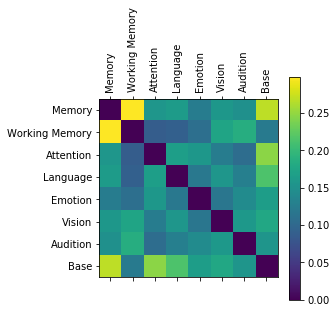

In [11]:
mutual_matrix_lou=np.zeros([len(domains),len(domains)])
for x,y in enumerate(domains):
    for a,b in enumerate(domains):
        mutual_matrix_lou[x][a]=mod.mutual_information(Louvain_part[y],Louvain_part[b])
np.fill_diagonal(mutual_matrix_lou,0)
plt.matshow(mutual_matrix_lou)        
plt.xticks(range(len(domains)), domains, rotation='90')
plt.yticks(range(len(domains)), domains)
plt.colorbar()

In [13]:
lou_rand_mod_list=pickle.load(open ('/Users/owner/Functional_Connectivity/Scripts/lou_rand_mod_list.pck', 'rb'))

IOError: [Errno 2] No such file or directory: '/Users/owner/Functional_Connectivity/Scripts/lou_rand_mod_list.pck'

Statistical Significance

In [ ]:
mean={}
std={}
z={}
for x in domains:
    mean[x]=np.mean(lou_rand_mod_list[x])
    std[x]=np.std(lou_rand_mod_list[x])
    z[x]=((community.modularity(G_part[x], G_nothresh[x]))-mean[x])/std[x]
    if z[x] > 1.96:
        print x, '| Q =', community.modularity(G_part[x], G_nothresh[x]), '| Z =', z[x], '| M =', mean[x]

Modular Frequency

In [12]:
nodes=['Cingulum_Ant_R_1','Cingulum_Ant_L_1','Cingulum_Ant_L_2','Cingulum_Ant_L_3','Cingulum_Ant_L_4','Cingulum_Ant_L_5','Cingulum_Ant_L_6','Cingulum_Ant_R_2','Cingulum_Ant_R_3','Cingulum_Ant_R_4','Cingulum_Ant_R_5','Frontal_Inf_Oper_L_1','Frontal_Inf_Oper_L_2','Frontal_Inf_Oper_L_3','Frontal_Inf_Oper_L_4','Frontal_Inf_Oper_R_1','Frontal_Inf_Oper_R_2','Frontal_Inf_Oper_R_3','Frontal_Inf_Oper_R_4','Frontal_Inf_Oper_R_5','Frontal_Inf_Oper_R_6','Frontal_Inf_Orb_L_1','Frontal_Inf_Orb_L_2','Frontal_Inf_Orb_L_3','Frontal_Inf_Orb_L_4','Frontal_Inf_Orb_L_5','Frontal_Inf_Orb_L_6','Frontal_Inf_Orb_L_7','Frontal_Inf_Orb_R_1','Frontal_Inf_Orb_R_2','Frontal_Inf_Orb_R_3','Frontal_Inf_Orb_R_4','Frontal_Inf_Orb_R_5','Frontal_Inf_Orb_R_6','Frontal_Inf_Orb_R_7','Frontal_Inf_Tri_L_1','Frontal_Inf_Tri_L_10','Frontal_Inf_Tri_L_2','Frontal_Inf_Tri_L_3','Frontal_Inf_Tri_L_4','Frontal_Inf_Tri_L_5','Frontal_Inf_Tri_L_6','Frontal_Inf_Tri_L_7','Frontal_Inf_Tri_L_8','Frontal_Inf_Tri_L_9','Frontal_Inf_Tri_R_1','Frontal_Inf_Tri_R_2','Frontal_Inf_Tri_R_3','Frontal_Inf_Tri_R_4','Frontal_Inf_Tri_R_5','Frontal_Inf_Tri_R_6','Frontal_Inf_Tri_R_7','Frontal_Inf_Tri_R_8','Frontal_Inf_Tri_R_9','Frontal_Mid_L_1','Frontal_Mid_L_10','Frontal_Mid_L_11','Frontal_Mid_L_12','Frontal_Mid_L_13','Frontal_Mid_L_14','Frontal_Mid_L_15','Frontal_Mid_L_16','Frontal_Mid_L_17','Frontal_Mid_L_18','Frontal_Mid_L_19','Frontal_Mid_L_2','Frontal_Mid_L_3','Frontal_Mid_L_4','Frontal_Mid_L_5','Frontal_Mid_L_6','Frontal_Mid_L_7','Frontal_Mid_L_8','Frontal_Mid_L_9','Frontal_Mid_Orb_L_1','Frontal_Mid_Orb_L_2','Frontal_Mid_Orb_L_3','Frontal_Mid_Orb_R_1','Frontal_Mid_Orb_R_2','Frontal_Mid_Orb_R_3','Frontal_Mid_Orbb_L_1','Frontal_Mid_Orbb_L_2','Frontal_Mid_Orbb_L_3','Frontal_Mid_Orbb_L_4','Frontal_Mid_Orbb_R_1','Frontal_Mid_Orbb_R_2','Frontal_Mid_Orbb_R_3','Frontal_Mid_Orbb_R_4','Frontal_Mid_R_1','Frontal_Mid_R_10','Frontal_Mid_R_11','Frontal_Mid_R_12','Frontal_Mid_R_13','Frontal_Mid_R_14','Frontal_Mid_R_15','Frontal_Mid_R_16','Frontal_Mid_R_17','Frontal_Mid_R_18','Frontal_Mid_R_19','Frontal_Mid_R_2','Frontal_Mid_R_20','Frontal_Mid_R_3','Frontal_Mid_R_4','Frontal_Mid_R_5','Frontal_Mid_R_6','Frontal_Mid_R_7','Frontal_Mid_R_8','Frontal_Mid_R_9','Frontal_Sup_L_1','Frontal_Sup_L_10','Frontal_Sup_L_11','Frontal_Sup_L_12','Frontal_Sup_L_13','Frontal_Sup_L_14','Frontal_Sup_L_2','Frontal_Sup_L_3','Frontal_Sup_L_4','Frontal_Sup_L_5','Frontal_Sup_L_6','Frontal_Sup_L_7','Frontal_Sup_L_8','Frontal_Sup_L_9','Frontal_Sup_Medial_L_1','Frontal_Sup_Medial_L_10','Frontal_Sup_Medial_L_11','Frontal_Sup_Medial_L_12','Frontal_Sup_Medial_L_2','Frontal_Sup_Medial_L_3','Frontal_Sup_Medial_L_4','Frontal_Sup_Medial_L_5','Frontal_Sup_Medial_L_6','Frontal_Sup_Medial_L_7','Frontal_Sup_Medial_L_8','Frontal_Sup_Medial_L_9','Frontal_Sup_Medial_R_1','Frontal_Sup_Medial_R_2','Frontal_Sup_Medial_R_3','Frontal_Sup_Medial_R_4','Frontal_Sup_Medial_R_5','Frontal_Sup_Medial_R_6','Frontal_Sup_Medial_R_7','Frontal_Sup_Medial_R_8','Frontal_Sup_Medial_R_9','Frontal_Sup_Orb_L_1','Frontal_Sup_Orb_L_2','Frontal_Sup_Orb_L_3','Frontal_Sup_Orb_L_4','Frontal_Sup_Orb_R_1','Frontal_Sup_Orb_R_2','Frontal_Sup_Orb_R_3','Frontal_Sup_Orb_R_4','Frontal_Sup_R_1','Frontal_Sup_R_10','Frontal_Sup_R_11','Frontal_Sup_R_12','Frontal_Sup_R_13','Frontal_Sup_R_14','Frontal_Sup_R_15','Frontal_Sup_R_16','Frontal_Sup_R_2','Frontal_Sup_R_3','Frontal_Sup_R_4','Frontal_Sup_R_5','Frontal_Sup_R_6','Frontal_Sup_R_7','Frontal_Sup_R_8','Frontal_Sup_R_9','Precentral_L_1','Precentral_L_10','Precentral_L_11','Precentral_L_12','Precentral_L_13','Precentral_L_14','Precentral_L_2','Precentral_L_3','Precentral_L_4','Precentral_L_5','Precentral_L_6','Precentral_L_7','Precentral_L_8','Precentral_L_9','Precentral_R_1','Precentral_R_10','Precentral_R_11','Precentral_R_12','Precentral_R_13','Precentral_R_14','Precentral_R_2','Precentral_R_3','Precentral_R_4','Precentral_R_5','Precentral_R_6','Precentral_R_7','Precentral_R_8','Precentral_R_9','Rectus_L_1','Rectus_L_2','Rectus_L_3','Rectus_R_1','Rectus_R_2','Rectus_R_3','Rolandic_Oper_L_3','Rolandic_Oper_L_4','Rolandic_Oper_R_3','Rolandic_Oper_R_4','Rolandic_Oper_R_5','Supp_Motor_Area_L_1','Supp_Motor_Area_L_2','Supp_Motor_Area_L_3','Supp_Motor_Area_L_4','Supp_Motor_Area_L_5','Supp_Motor_Area_L_6','Supp_Motor_Area_L_7','Supp_Motor_Area_L_8','Supp_Motor_Area_L_9','Supp_Motor_Area_R_1','Supp_Motor_Area_R_2','Supp_Motor_Area_R_3','Supp_Motor_Area_R_4','Supp_Motor_Area_R_5','Supp_Motor_Area_R_6','Supp_Motor_Area_R_7','Supp_Motor_Area_R_8','Supp_Motor_Area_R_9']

In [13]:
modular_freq=np.zeros([223,223])
for x in domains:
        for h,n in enumerate(nodes):
            if n in G_part[x].keys():
                for f,m in enumerate(nodes):
                    if m in G_part[x].keys():
                        if n != m:
                            if G_part[x][n]==G_part[x][m]:
                                modular_freq[h][f]=modular_freq[h][f]+1
                            if modular_freq[h][f]==9:
                                print n, m, modular_freq[h][f]

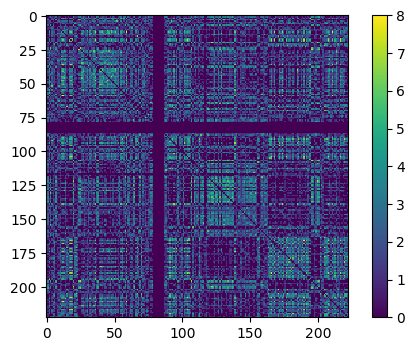

In [14]:
figu=plt.figure(dpi=100)
plt.imshow(modular_freq, interpolation='nearest')
plt.colorbar()

# Consensus

In [ ]:
#run if havent created random arrays. If already have, skip
random_array={x: myfunctions.random_modular_matrix(G_nothresh[x], iterations=10) for x in domains}

In [ ]:
for x in domains:
    pickle.dump(random_array[x], open ('/Users/owner/PFC_MetaConnectome/Results/Modularity_nothresh/Random_matrix/Random_'+x+'_modular_matrix_nothresh.pck','wb'))

In [15]:
random_array={x: pickle.load(open ('/Users/owner/PFC_MetaConnectome/Results/Modularity_nothresh/Random_matrix/Random_'+x+'_modular_matrix_nothresh.pck','rb')) for x in domains}
consensus_array={x: myfunctions.consensus_modular_matrix(G_nothresh[x], G_part[x], bct_partition[x], random_array[x][1]) for x in domains}
n_nodes={x: len(range(nx.number_of_nodes(G_nothresh[x]))) for x in domains}
nodes={x: dict(zip(range(n_nodes[x]), G_nothresh[x].nodes())) for x in domains}
con_G={x: nx.from_numpy_matrix(consensus_array[x]) for x in domains}
con_G={x: nx.relabel_nodes(con_G[x], nodes[x]) for x in domains}
con_lou={x: community.best_partition(con_G[x]) for x in domains}
con_lou_G={x: brainmap.make_brainx_style_partition(con_lou[x]) for x in domains}
for x in domains:
    print "Louvain Modularity: ", x, '|', community.modularity(con_lou[x], con_G[x]),':', len(con_lou_G[x])

Louvain Modularity:  Memory | 0.428652525967 : 3
Louvain Modularity:  Working Memory | 0.561950777887 : 5
Louvain Modularity:  Attention | 0.407144227041 : 3
Louvain Modularity:  Language | 0.34149189454 : 3
Louvain Modularity:  Emotion | 0.488740825528 : 4
Louvain Modularity:  Vision | 0.445558377449 : 5
Louvain Modularity:  Audition | 0.500779216704 : 12
Louvain Modularity:  Base | 0.454706535584 : 3


Mutual Information

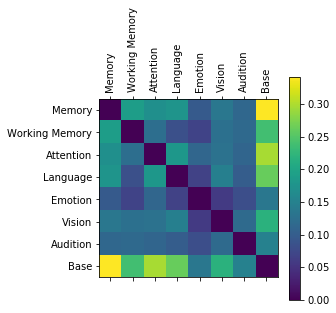

In [16]:
mutual_matrix_con=np.zeros([len(domains),len(domains)])
for x,y in enumerate(domains):
    for a,b in enumerate(domains):
        mutual_matrix_con[x][a]=mod.mutual_information(con_lou_G[y],con_lou_G[b])
np.fill_diagonal(mutual_matrix_con,0)
plt.matshow(mutual_matrix_con)        
plt.xticks(range(len(domains)), domains, rotation='90')
plt.yticks(range(len(domains)), domains)
plt.colorbar()
plt.savefig('/Users/owner/PFC_MetaConnectome/Results/Consensus_Mutual_Mat.jpg')

### Second Louvain Pass For Task General Consensus

In [17]:
out_nodes = []
for mod in con_lou_G['Base']:
    for node in mod:
        if node not in con_lou_G['Base'][1]:
            out_nodes.append(node)

In [18]:
copy_net = con_G['Base'].copy()
copy_net.remove_nodes_from(out_nodes)

In [19]:
secondPass_part = community.best_partition(copy_net)
secondPass_G = brainmap.make_brainx_style_partition(secondPass_part)

BrainNet Partition File

In [20]:
for x in domains:
    myfunctions.node_file(con_lou[x], y=basic_metrics[x]['between_cent'], filename='Consensus_nothresh_nosim_'+x+'.csv' )
    csv_file = '/Users/owner/Desktop/BrainImagingViewer/BrainNetViewer_20171031/Data/NodeFiles/Consensus_nothresh_nosim_'+x+'.csv' 
    txt_file = '/Users/owner/Desktop/BrainImagingViewer/BrainNetViewer_20171031/Data/NodeFiles/Consensus/Consensus_nothresh_nosim_'+x+'.node'
    with open(txt_file, "w") as my_output_file:
        with open(csv_file, "r") as my_input_file:
            [ my_output_file.write(" ".join(row)+'\n') for row in csv.reader(my_input_file)]
        my_output_file.close()

NameError: name 'basic_metrics' is not defined

### Consensus on only Lateral Nodes

In [21]:
#Lateral Regions: Mid, Sup, Inf_Oper/Tri
side = ['R','L']
sub_reg = ['Mid','Sup','Inf_Oper','Inf_Tri']
matches = [x + '_' + y for x in sub_reg for y in side]

lat_PFC = dict()
for x in domains:
    copy_net = G_nothresh[x].copy()
    non_laterals = []
    for node in copy_net.nodes():
        if not any(r in node for r in matches):
            non_laterals.append(node)
    lat_PFC[x] = copy_net
    lat_PFC[x].remove_nodes_from(non_laterals)

In [22]:
#Run modularity algorithms on separately
#BCT Newman
bctLat_mod={}
bctLat_part={}
bctLat_partition={}
for x in domains:
    bctLat_mod[x]=bct.modularity_und(np.squeeze(np.asarray(nx.to_numpy_matrix(lat_PFC[x]))))
    bctLat_part[x]=dict(zip(lat_PFC[x].nodes(), bctLat_mod[x][0]))
    bctLat_partition[x]=brainmap.make_brainx_style_partition(bctLat_part[x])
    print x, '|', bctLat_mod[x][1],'|',len(bctLat_partition[x])

Memory | 0.164956316676 | 3
Working Memory | 0.227111643047 | 6
Attention | 0.1674187318 | 7
Language | 0.364227340955 | 4
Emotion | 0.164027709032 | 6
Vision | 0.315266436498 | 8
Audition | 0.452302469248 | 6
Base | 0.145237329252 | 4


In [23]:
#Louvain
louLat_part={}
gLat_part={}
for x in domains:
    gLat_part[x]=community.best_partition(lat_PFC[x])
    louLat_part[x]=brainmap.make_brainx_style_partition(gLat_part[x])
    print "Louvain Modularity: ", x, '|', community.modularity(gLat_part[x], lat_PFC[x]),':', len(louLat_part[x])

Louvain Modularity:  Memory | 0.189801164655 : 5
Louvain Modularity:  Working Memory | 0.250637531103 : 9
Louvain Modularity:  Attention | 0.205590179374 : 8
Louvain Modularity:  Language | 0.382503806773 : 6
Louvain Modularity:  Emotion | 0.219348171982 : 7
Louvain Modularity:  Vision | 0.386645669241 : 9
Louvain Modularity:  Audition | 0.470646763427 : 11
Louvain Modularity:  Base | 0.15847410017 : 3


In [24]:
#Consensus Time
randomLat_array={x: myfunctions.random_modular_matrix(lat_PFC[x], iterations=10) for x in domains}

In [25]:
consensusLat_array={x: myfunctions.consensus_modular_matrix(lat_PFC[x], gLat_part[x], bctLat_partition[x], randomLat_array[x][1]) for x in domains}
n_nodes={x: len(range(nx.number_of_nodes(lat_PFC[x]))) for x in domains}
nodes={x: dict(zip(range(n_nodes[x]), lat_PFC[x].nodes())) for x in domains}
conLat_G={x: nx.from_numpy_matrix(consensusLat_array[x]) for x in domains}
conLat_G={x: nx.relabel_nodes(conLat_G[x], nodes[x]) for x in domains}
conLat_lou={x: community.best_partition(conLat_G[x]) for x in domains}
conLat_lou_G={x: brainmap.make_brainx_style_partition(conLat_lou[x]) for x in domains}
for x in domains:
    print "Louvain Modularity: ", x, '|', community.modularity(conLat_lou[x], conLat_G[x]),':', len(conLat_lou_G[x])

Louvain Modularity:  Memory | 0.488432294765 : 3
Louvain Modularity:  Working Memory | 0.522736846738 : 4
Louvain Modularity:  Attention | 0.394399754171 : 5
Louvain Modularity:  Language | 0.467027586343 : 4
Louvain Modularity:  Emotion | 0.341509374643 : 5
Louvain Modularity:  Vision | 0.455989552383 : 5
Louvain Modularity:  Audition | 0.341225436482 : 6
Louvain Modularity:  Base | 0.577810446281 : 3


In [26]:
lat_Part = dict()
lat_BxPart = dict()
for x in domains:
    lat_Part[x] = community.best_partition(lat_PFC[x])
    lat_BxPart[x] = brainmap.make_brainx_style_partition(lat_Part[x])

# Each Lateral Region and 2nd Pass Consensus Mod Assignment

In [40]:
#Each Lateral Region and Second pass community assignment
pd.DataFrame.from_dict(lat_Part['Base'], orient = 'index')

,0
Frontal_Mid_R_9,2
Frontal_Sup_L_1,0
Frontal_Mid_R_18,1
Frontal_Mid_R_19,0
Frontal_Sup_L_4,0
Frontal_Sup_L_5,0
Frontal_Sup_L_6,1
Frontal_Sup_L_7,1
Frontal_Mid_R_12,1
Frontal_Mid_R_13,1


In [48]:
df_dict = {}
for x in domains:
    df = pd.read_csv(path, header=None, names=['x','y','z','regions'], sep='\t')
    df.insert(4,'module',0,True)
    df.insert(5,'size',0,True)
    df.insert(6,'nodes',0,True)
    df=df[['x','y','z','module','size','regions','nodes']]
    
    df_left_lateral = []
    df_right_lateral = []
    
    df_left_med = []
    df_right_med = []
    for region in conLat_lou[x]:
        for n in range(len(df)):
            if region == df.loc[n,'regions']:
                df.loc[n,'nodes'] = region
                df.loc[n, 'module'] = conLat_lou[x][region]
                df.loc[n, 'size'] = 1
    df=df[['x','y','z','module','size','nodes']]
    df_dict[x]=df[df.nodes != 0]
    df_dict[x].index=range(len(df_dict[x]))
    
    df_left_lateral = df_dict[x].copy()
    df_right_lateral = df_dict[x].copy()
    df_left_med = df_dict[x].copy()
    df_right_med= df_dict[x].copy()
    for n,node in enumerate(df_dict[x]['nodes']):

        if  sum([node.find('R'),node.find('Med')]) != -2:
            df_left_lateral.loc[n,'nodes'] = 0
        if sum([node.find('L'),node.find('Med')]) != -2:
            df_right_lateral.loc[n,'nodes'] = 0  
                
    #seperate right and left for clearer images
    df_left_lateral = df_left_lateral[df_left_lateral.nodes != 0]
    df_right_lateral = df_right_lateral[df_right_lateral.nodes !=0]
  
    df_left_lateral.to_csv(outdir+'Iso_Con_'+x+'_Lateral_L.csv', header=False, index=False, index_label=False)
    df_right_lateral.to_csv(outdir+'Iso_Con_'+x+'_Lateral_R.csv', header=False, index=False, index_label=False)
   
    for side in ['L','R']:
        csv_file = outdir+'Iso_Con_'+x+'_Lateral_'+side+'.csv'
        txt_file = '/Users/owner/Documents/MATLAB/Add_Ons/BrainNetViewer_20171031/Data/NodeFiles/Nothresh/Bilateral/Iso_Lat/Iso_Lou_'+x+'_Lateral_'+side+'.node'
        with open(txt_file, "w") as my_output_file:
            with open(csv_file, "r") as my_input_file:
                [ my_output_file.write(" ".join(row)+'\n') for row in csv.reader(my_input_file)]
            my_output_file.close()

### Left/Right Images

In [30]:
df_dict = {}
for x in domains:
    df = pd.read_csv(path, header=None, names=['x','y','z','regions'], sep='\t')
    df.insert(4,'module',0,True)
    df.insert(5,'size',0,True)
    df.insert(6,'nodes',0,True)
    df=df[['x','y','z','module','size','regions','nodes']]
    
    df_left_lateral = []
    df_right_lateral = []
    
    df_left_med = []
    df_right_med = []
    for region in con_lou[x]:
        for n in range(len(df)):
            if region == df.loc[n,'regions']:
                df.loc[n,'nodes'] = region
                df.loc[n, 'module'] = con_lou[x][region]
                df.loc[n, 'size'] = 1
    df=df[['x','y','z','module','size','nodes']]
    df_dict[x]=df[df.nodes != 0]
    df_dict[x].index=range(len(df_dict[x]))
    
    df_left_lateral = df_dict[x].copy()
    df_right_lateral = df_dict[x].copy()
    df_left_med = df_dict[x].copy()
    df_right_med= df_dict[x].copy()
    for n,node in enumerate(df_dict[x]['nodes']):

        if  sum([node.find('R'),node.find('Med')]) != -2:
            df_left_lateral.loc[n,'nodes'] = 0
        if sum([node.find('L'),node.find('Med')]) != -2:
            df_right_lateral.loc[n,'nodes'] = 0  
            
        if all(z in node for z in ['L','Med'])==False:
            df_left_med.loc[n,'nodes'] = 0
            
        if all(z in node for z in ['R','Med'])==False:
            df_right_med.loc[n,'nodes'] = 0
            
                
    #seperate right and left for clearer images
    df_left_lateral = df_left_lateral[df_left_lateral.nodes != 0]
    df_right_lateral = df_right_lateral[df_right_lateral.nodes !=0]
    
    df_left_med = df_left_med[df_left_med.nodes != 0]
    df_right_med = df_right_med[df_right_med.nodes != 0]
    
    
    df_left_lateral.to_csv(outdir+'Consensus_'+x+'_Lateral_L.csv', header=False, index=False, index_label=False)
    df_right_lateral.to_csv(outdir+'Consensus_'+x+'_Lateral_R.csv', header=False, index=False, index_label=False)
    
    df_left_med.to_csv(outdir+'Consensus_'+x+'_Med_L.csv', header=False, index=False, index_label=False)
    df_right_med.to_csv(outdir+'Consensus_'+x+'_Med_R.csv', header=False, index=False, index_label=False)
    
    for side in ['L','R']:
        for area in ['Lateral','Med']:
            csv_file = outdir+'Consensus_'+x+'_'+area+'_'+side+'.csv'
            txt_file = '/Users/owner/Documents/MATLAB/Add_Ons/BrainNetViewer_20171031/Data/NodeFiles/Consensus/Consensus_'+x+'_'+area+'_'+side+'.node'
            with open(txt_file, "w") as my_output_file:
                with open(csv_file, "r") as my_input_file:
                    [ my_output_file.write(" ".join(row)+'\n') for row in csv.reader(my_input_file)]
                my_output_file.close()


Second Pass Images

In [31]:
df = pd.read_csv(path, header=None, names=['x','y','z','regions'], sep='\t')
df.insert(4,'module',0,True)
df.insert(5,'size',0,True)
df.insert(6,'nodes',0,True)
df=df[['x','y','z','module','size','regions','nodes']]

df_left_lateral = []
df_right_lateral = []

df_left_med = []
df_right_med = []
for region in secondPass_part:
    for n in range(len(df)):
        if region == df.loc[n,'regions']:
            df.loc[n,'nodes'] = region
            df.loc[n, 'module'] = secondPass_part[region]
            df.loc[n, 'size'] = 1
df=df[['x','y','z','module','size','nodes']]
df_new=df[df.nodes != 0]
df_new.index=range(len(df_new))

df_left_lateral = df_new.copy()
df_right_lateral = df_new.copy()
df_left_med = df_new.copy()
df_right_med= df_new.copy()
for n,node in enumerate(df_new['nodes']):

    if  sum([node.find('R'),node.find('Med')]) != -2:
        df_left_lateral.loc[n,'nodes'] = 0
    if sum([node.find('L'),node.find('Med')]) != -2:
        df_right_lateral.loc[n,'nodes'] = 0  

    if all(z in node for z in ['L','Med'])==False:
        df_left_med.loc[n,'nodes'] = 0

    if all(z in node for z in ['R','Med'])==False:
        df_right_med.loc[n,'nodes'] = 0


#seperate right and left for clearer images
df_left_lateral = df_left_lateral[df_left_lateral.nodes != 0]
df_right_lateral = df_right_lateral[df_right_lateral.nodes !=0]

df_left_med = df_left_med[df_left_med.nodes != 0]
df_right_med = df_right_med[df_right_med.nodes != 0]


df_left_lateral.to_csv(outdir+'Consensus_Mod2_SecondPass_Lateral_L.csv', header=False, index=False, index_label=False)
df_right_lateral.to_csv(outdir+'Consensus_Mod2_SecondPass_Lateral_R.csv', header=False, index=False, index_label=False)

df_left_med.to_csv(outdir+'Consensus_Mod2_SecondPass_Med_L.csv', header=False, index=False, index_label=False)
df_right_med.to_csv(outdir+'Consensus_Mod2_SecondPass_Med_R.csv', header=False, index=False, index_label=False)

for side in ['L','R']:
    for area in ['Lateral','Med']:
        csv_file = outdir+'Consensus_Mod2_SecondPass_'+area+'_'+side+'.csv'
        txt_file = '/Users/owner/Documents/MATLAB/Add_Ons/BrainNetViewer_20171031/Data/NodeFiles/Consensus/Consensus_Mod2_SecondPass_'+area+'_'+side+'.node'
        with open(txt_file, "w") as my_output_file:
            with open(csv_file, "r") as my_input_file:
                [ my_output_file.write(" ".join(row)+'\n') for row in csv.reader(my_input_file)]
            my_output_file.close()

# Merged Network Modularity 

In [4]:
G_merge = {}
for x in domains:
    filename = 'G_merged_'+x+'_.pck'
    workdir = '/Users/owner/Functional_Connectivity/Results/G_jaccard_graphs/Unthresholded_G_jaccard/Merged_Graphs/'
    output = workdir + filename
    G_merge[x] = pickle.load(open (output, 'rb'))

## BCT Newman Modularity

In [5]:
modularity_dir ='/Users/owner/Functional_Connectivity/Results/Modularity_nothresh/Merged/'
bct_mod_merge={}
bct_part_merge={}
bct_partition_merge={}
for x in domains:
    bct_mod_merge[x]=bct.modularity_und(np.squeeze(np.asarray(nx.to_numpy_matrix(G_merge[x]))))
    bct_part_merge[x]=dict(zip(G_merge[x].nodes(), bct_mod_merge[x][0]))
    bct_partition_merge[x]=brainmap.make_brainx_style_partition(bct_part_merge[x])
    pickle.dump(bct_part_merge[x],open(modularity_dir+'Newman_part_'+x+'.pck','wb'))

In [ ]:
for x in domains:
    print x, '|', bct_mod_merge[x][1]

In [ ]:
mutual_matrix_bct_new_merge=np.zeros([len(domains),len(domains)])
for x,y in enumerate(domains):
    for a,b in enumerate(domains):
        mutual_matrix_bct_new_merge[x][a]=mod.mutual_information(bct_partition_merge[y],bct_partition_merge[b])
np.fill_diagonal(mutual_matrix_bct_new_merge,0)
plt.matshow(mutual_matrix_bct_new_merge)        
plt.xticks(range(len(domains)), domains, rotation='90')
plt.yticks(range(len(domains)), domains)
plt.colorbar()

## Louvain

In [6]:
G_noweight_merge={x: brainmap.remove_weight_edge_attribute(G_merge[x]) for x in domains }

In [7]:
Louvain_part_merge={}
Dendogram_merge={}
G_part_merge={}
for x in domains:
    G_part_merge[x]=community.best_partition(G_merge[x])
    Dendogram_merge[x]=community.generate_dendrogram(G_merge[x])
    filename='Louvain_part_'+x+'_merge.pck'
    output=modularity_dir+filename
    pickle.dump (G_part_merge[x], open(output, 'wb'))
    #G_part_merge[x]=pickle.load(open(output, 'rb'))
    Louvain_part_merge[x]=brainmap.make_brainx_style_partition(G_part_merge[x])
    print "Louvain Modularity: ", x, '|', community.modularity(G_part_merge[x], G_merge[x]),':', len(Louvain_part_merge[x])

Louvain Modularity:  Memory | 0.0704817412436 : 4
Louvain Modularity:  Working Memory | 0.121429498314 : 4
Louvain Modularity:  Emotion | 0.0288107430089 : 4
Louvain Modularity:  Attention | 0.0675572264496 : 4
Louvain Modularity:  Language | 0.0842545797338 : 3
Louvain Modularity:  Vision | 0.131028531184 : 4
Louvain Modularity:  Audition | 0.17995394756 : 4
Louvain Modularity:  Base | 0.109673271954 : 4
Louvain Modularity:  Rest | 0.0368293598894 : 3


In [ ]:
mutual_matrix_lou_merge=np.zeros([len(domains),len(domains)])
for x,y in enumerate(domains):
    for a,b in enumerate(domains):
        mutual_matrix_lou_merge[x][a]=mod.mutual_information(Louvain_part_merge[y],Louvain_part_merge[b])
np.fill_diagonal(mutual_matrix_lou_merge,0)
plt.matshow(mutual_matrix_lou_merge)        
plt.xticks(range(len(domains)), domains, rotation='90')
plt.yticks(range(len(domains)), domains)
plt.colorbar()

### Modular Freq

In [ ]:
nodes=['Cingulum_Ant_R','Cingulum_Ant_L',
       'Frontal_Inf_Oper_L','Frontal_Inf_Oper_R',
       'Frontal_Inf_Orb_L','Frontal_Inf_Orb_R',
       'Frontal_Inf_Tri_L','Frontal_Inf_Tri_R',
       'Frontal_Mid_L','Frontal_Mid_R',
       'Frontal_Mid_Orb_L','Frontal_Mid_Orb_R',
       'Frontal_Med_Orb_L','Frontal_Med_Orb_R',
       'Frontal_Sup_L','Frontal_Sup_R',
       'Frontal_Sup_Medial_L','Frontal_Sup_Medial_R',
       'Frontal_Sup_Orb_L','Frontal_Sup_Orb_R',
       'Precentral_L','Precentral_R',
       'Rectus_L','Rectus_R',
       'Rolandic_Oper_L','Rolandic_Oper_R',
       'Supp_Motor_Area_L','Supp_Motor_Area_R']

In [ ]:
modular_freq_merge=np.zeros([28,28])
for x in domains:
        for h,n in enumerate(nodes):
            if n in G_part_merge[x].keys():
                for f,m in enumerate(nodes):
                    if m in G_part_merge[x].keys():
                        if n != m:
                            if G_part_merge[x][n]==G_part_merge[x][m]:
                                modular_freq_merge[h][f]=modular_freq_merge[h][f]+1
                            if modular_freq_merge[h][f]==7:
                                print n, m, modular_freq_merge[h][f]

In [ ]:
figu=plt.figure(dpi=100)
plt.imshow(modular_freq_merge, interpolation='nearest')
plt.colorbar()

In [8]:
random_array_merge={x: myfunctions.random_modular_matrix(G_merge[x], iterations=10) for x in tqdm(domains)}

100%|██████████| 9/9 [00:02<00:00,  4.34it/s]


In [9]:
#random_array={x: pickle.load(open ('/Users/owner/Functional_Connectivity/Results/Modularity_nothresh/Random_matrix/Random_'+x+'_modular_matrix_nothresh.pck','rb')) for x in domains}
consensus_array_merge={x: myfunctions.consensus_modular_matrix(G_merge[x], G_part_merge[x], bct_partition_merge[x], random_array_merge[x][1]) for x in tqdm(domains)}
n_nodes={x: len(range(nx.number_of_nodes(G_merge[x]))) for x in domains}
nodes={x: dict(zip(range(n_nodes[x]), G_merge[x].nodes())) for x in domains}
con_G_merge={x: nx.from_numpy_matrix(consensus_array_merge[x]) for x in domains}
con_G_merge={x: nx.relabel_nodes(con_G_merge[x], nodes[x]) for x in domains}
con_lou_merge={x: community.best_partition(con_G_merge[x]) for x in domains}
con_lou_G_merge={x: brainmap.make_brainx_style_partition(con_lou_merge[x]) for x in domains}
for x in domains:
    print "Louvain Modularity: ", x, '|', community.modularity(con_lou_merge[x], con_G_merge[x]),':', len(con_lou_G_merge[x])
    pickle.dump(con_lou_merge[x], open(modularity_dir+'Con_Lou_part_'+x+'_.pck','wb'))

100%|██████████| 9/9 [00:00<00:00, 213.72it/s]

Louvain Modularity:  Memory | 0.405422967864 : 3
Louvain Modularity:  Working Memory | 0.542620534166 : 4
Louvain Modularity:  Emotion | 0.326717282666 : 2
Louvain Modularity:  Attention | 0.389035013888 : 3
Louvain Modularity:  Language | 0.458250020953 : 3
Louvain Modularity:  Vision | 0.352447041636 : 2
Louvain Modularity:  Audition | 0.386354703468 : 4
Louvain Modularity:  Base | 0.417570153061 : 3
Louvain Modularity:  Rest | 0.427198753463 : 2
